In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cryptocmd import CmcScraper
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import requests
import datetime
import numpy as np
import pandas as pd

In [3]:
__version__ = '0.1.2'

In [4]:
# initialise scraper without time interval
scraper = CmcScraper("BTC")

# get raw data as list of list
headers, data = scraper.get_data()

# Pandas dataFrame for the same data
df = scraper.get_dataframe()

In [5]:
# inizio analisi (timestamp=0)
inizio=datetime.datetime(2013,1,1).timestamp()

In [6]:
url = "https://api.watcher.guru/bitcoinhalving/predictions"
current_status=requests.get(url).json()
current_status

{'meta': {'is_complete': False,
  'average_sec_between_blocks': 589.4551343112973,
  'previous_halving_block_number': 630000,
  'minus_blocks': 5249},
 'current': {'block_number': 834751, 'timestamp': 1710478958},
 'target': {'block_number': 840000, 'predicted_timestamp': 1713573008}}

In [7]:
btc_predicted_halving = datetime.datetime.fromtimestamp(current_status["target"]["predicted_timestamp"])


In [8]:
history = pd.DataFrame({"Date":[
    datetime.datetime(2009,1,3),
    datetime.datetime(2012,11,28),
    datetime.datetime(2016,7,9),
    datetime.datetime(2020,5,11),
    btc_predicted_halving
], "Block": [0,210000, 420000, 630000, 840000]})
# calc the cycle length and the offset -1
history["cycle_length"] = (history["Date"].diff().dt.days).shift(-1)
history["cycle"] = [1,2,3,4,5]
history["Halving"] = history["Date"]
history

,Date,Block,cycle_length,cycle,Halving
0,2009-01-03 00:00:00,0,1425.0,1,2009-01-03 00:00:00
1,2012-11-28 00:00:00,210000,1319.0,2,2012-11-28 00:00:00
2,2016-07-09 00:00:00,420000,1402.0,3,2016-07-09 00:00:00
3,2020-05-11 00:00:00,630000,1440.0,4,2020-05-11 00:00:00
4,2024-04-20 00:30:08,840000,NaN,5,2024-04-20 00:30:08


In [9]:
prices = df[["Date", "Close"]].copy()
prices = prices.merge(history, how="outer", on="Date")
prices.sort_values("Date", inplace=True)

# cycle
prices[["Block", "cycle_length", "cycle", "Halving"]] = prices[["Block", "cycle_length", "cycle","Halving"]].fillna(method="ffill")
prices = prices[prices["Close"].notna()]
prices["cycle_progress"] = ((prices["Date"] - prices["Halving"]).dt.days)/prices["cycle_length"]

# ath
prices["ATH"] = prices["Close"].cummax()
prices["Close_ath_ratio"] = prices["Close"]/prices["ATH"]

prices["distance_ath_perc"] = ((prices["Close"] - prices["ATH"]) / prices["ATH"])

norm = mcolors.Normalize(
    vmin=(prices["distance_ath_perc"].min()), vmax=(prices["distance_ath_perc"].max())
)
cmap = plt.get_cmap('cool')

prices["color"] = prices["distance_ath_perc"].apply(lambda x: mcolors.to_hex(cmap(norm(x))))



# reset index
prices.reset_index(inplace=True, drop=True)
prices

/tmp/ipykernel_1848/3572319127.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices[["Block", "cycle_length", "cycle", "Halving"]] = prices[["Block", "cycle_length", "cycle","Halving"]].fillna(method="ffill")


,Date,Close,Block,cycle_length,cycle,Halving,cycle_progress,ATH,Close_ath_ratio,distance_ath_perc,color
0,2013-04-28,127.954255,210000.0,1319.0,2.0,2012-11-28,0.114481,127.954255,1.000000,0.000000,#ff00ff
1,2013-04-29,144.539993,210000.0,1319.0,2.0,2012-11-28,0.115239,144.539993,1.000000,0.000000,#ff00ff
2,2013-04-30,139.000000,210000.0,1319.0,2.0,2012-11-28,0.115997,144.539993,0.961672,-0.038328,#f40bff
3,2013-05-01,116.989998,210000.0,1319.0,2.0,2012-11-28,0.116755,144.539993,0.809395,-0.190605,#c639ff
4,2013-05-02,105.209999,210000.0,1319.0,2.0,2012-11-28,0.117513,144.539993,0.727895,-0.272105,#ad52ff
...,...,...,...,...,...,...,...,...,...,...,...
3969,2024-03-10,69019.786364,630000.0,1440.0,4.0,2020-05-11,0.971528,69019.786364,1.000000,0.000000,#ff00ff
3970,2024-03-11,72123.903547,630000.0,1440.0,4.0,2020-05-11,0.972222,72123.903547,1.000000,0.000000,#ff00ff
3971,2024-03-12,71481.291594,630000.0,1440.0,4.0,2020-05-11,0.972917,72123.903547,0.991090,-0.008910,#fd02ff
3972,2024-03-13,73083.501328,630000.0,1440.0,4.0,2020-05-11,0.973611,73083.501328,1.000000,0.000000,#ff00ff


In [10]:
cycle_progress_dates=[]

for progress in [0.00, 0.25, 0.5, 0.75]:
    cycle_progress_dates.append(
        prices[abs((prices["cycle_progress"]-progress))<0.0005].groupby("cycle").first().reset_index()
    )

cycle_progress_dates = pd.concat(cycle_progress_dates)
cycle_progress_dates["cycle_progress"] = cycle_progress_dates["cycle_progress"].apply(lambda x: round(x,2))
# concat groyped dates as formatted strings
cycle_progress_dates = cycle_progress_dates.groupby("cycle_progress")[["Date"]].apply(
    lambda x: ''.join(f'{label}\n' for label in x["Date"].dt.strftime("%d-%m-%Y").to_list())
)

predicted_halving_string = r'$\bf{{{} \: (predicted)}}$'.format(btc_predicted_halving.strftime("%d-%m-%Y"))

cycle_progress_dates.iloc[0] = cycle_progress_dates.iloc[0] + predicted_halving_string
cycle_progress_dates

cycle_progress
0.00    09-07-2016\n11-05-2020\n$\bf{20-04-2024 \: (pr...
0.25                 24-10-2013\n24-06-2017\n06-05-2021\n
0.50                 18-09-2014\n10-06-2018\n01-05-2022\n
0.75                 14-08-2015\n26-05-2019\n26-04-2023\n
dtype: object

/tmp/ipykernel_1848/625583473.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


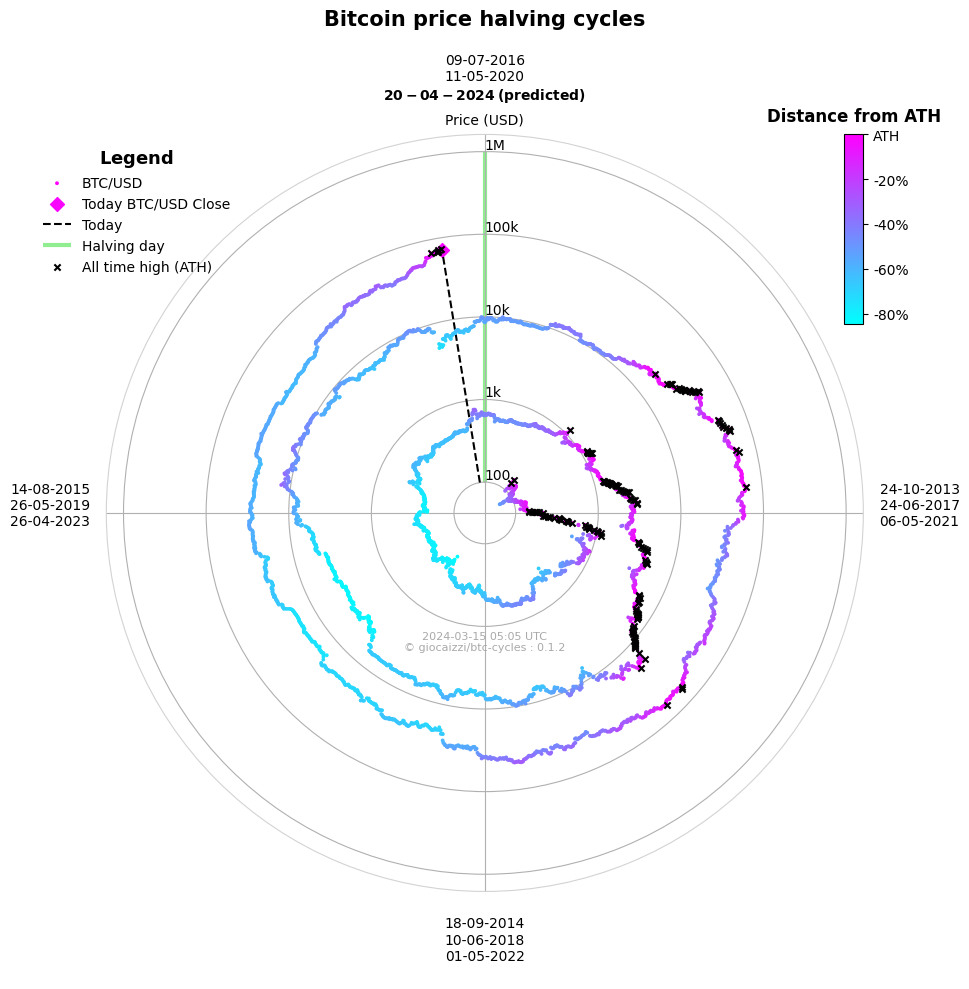

In [11]:
# Create a polar subplot
f, axes = plt.subplots(1, 1, subplot_kw=dict(polar=True), figsize=(10, 10))

# Plot data
axes.scatter(
    prices["cycle_progress"] * 2 * np.pi,
    prices["Close"].to_numpy(),
    s=3,
    # markersize=1,
    c=prices["color"],
    zorder=9,
)


# now
axes.scatter(
    prices["cycle_progress"].to_numpy()[-1] * 2 * np.pi,
    prices["Close"].to_numpy()[-1],
    marker="D",
    c=prices["color"].to_numpy()[-1],
    s=50,
    zorder=8,
)
axes.vlines(
    prices["cycle_progress"].to_numpy()[-1] * 2 * np.pi,
    100,
    prices["Close"].to_numpy()[-1],
    color="k",
    linestyle="--",
    zorder=8,
)

# halving
axes.vlines(
    0,
    100,
    1000000,
    color="lightgreen",
    linewidth=3,
    zorder=0,
)


# # Plot ATHs
aths = prices[prices["Close_ath_ratio"] == 1]
axes.scatter(
    aths["cycle_progress"] * 2 * np.pi,
    aths["Close"],
    marker="x",
    c="k",
    s=20,
    zorder=10,
)

# # plot bottoms
# axes.scatter(
#     cycle_bottoms["cycle_progress"] * 2 * np.pi,
#     cycle_bottoms["Close"],
#     marker="o",
#     c="r",
#     s=20,
#     zorder=10,
# )


# format graph
# Set y-axis to logarithmic scale
axes.set_rscale("log")
# # Set direction (1 for clockwise, -1 for counterclockwise)
axes.set_theta_direction(-1)
axes.set_theta_offset(np.pi / 2.0)
axes.set_rgrids(
    [
        100,
        1000,
        10000,
        100000,
        1000000,
    ],
    labels=[
        "100",
        "1k",
        "10k",
        "100k",
        "1M",
    ],
)
# axes.set_xticklabels(
#     [
#         "Halving day",
#         "",
#         "",
#         "",
#         "Mid-cycle",
#     ]

# )
axes.set_xticks(
    np.linspace(0, 2 * np.pi, 4, endpoint=False),
)
axes.set_xticklabels(
    cycle_progress_dates,
    fontsize=10,
)
axes.set_rlabel_position(0)
axes.set_ylabel("Price (USD)", rotation=0)
axes.yaxis.set_label_coords(0.5, 1.01)
axes.tick_params(axis="both", which="major", pad=30)
[spine.set_edgecolor("lightgrey") for spine in axes.spines.values()]
axes.set_title(
    "Bitcoin price halving cycles",
    fontdict={"fontsize": 15, "fontweight": "bold"},
    pad=20,
)

# legend
axes.legend(
    ["BTC/USD", "Today BTC/USD Close", "Today", "Halving day", "All time high (ATH)"],
    loc="upper left",
    bbox_to_anchor=(-0.1, 1),
    fontsize=10,
    title="$\\bf{Legend}$",
    title_fontsize="13",
    # labelspacing=1.5,
    frameon=False,
)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
inset_ax = inset_axes(
    axes,
    width="2.5%",
    height="25%",
    # loc="upper right",
    bbox_to_anchor=(0, 0, 1, 1),
    bbox_transform=axes.transAxes,
    borderpad=0,
)

cbar = f.colorbar(
    sm,
    cax=inset_ax,
    orientation="vertical",
    ticks=[0, -0.2, -0.4, -0.6, -0.8, -1],
)
cbar.ax.set_yticklabels(["ATH", "-20%", "-40%", "-60%", "-80%", "-100%"])
inset_ax.set_title("Distance from ATH", fontdict={"fontweight": "bold"}, pad=10)

date = datetime.datetime.utcnow()
date_text = date.strftime("%Y-%m-%d %H:%M UTC")

# date, and copyright
axes.annotate(
    (
        f'{date_text}\n'
        f"© giocaizzi/btc-cycles : {__version__}"
    ),
    xy=(0.5, 0.33),
    xycoords="axes fraction",
    textcoords="axes fraction",
    fontsize=8,
    ha="center",
    va="center",
    color="darkgrey",
)

f.tight_layout()
f.savefig("bitcoin", dpi=300)